## Data acquisition and importing


In [39]:
#Importing libraries
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Read all the CSV files into datasets
df_job_postings = pd.read_csv("job_postings.csv")
df_company_industries = pd.read_csv("company_industries.csv")
df_companies = pd.read_csv("companies.csv")
df_company_specialities = pd.read_csv("company_specialities.csv")
df_benefits = pd.read_csv("benefits.csv") #Job benefits such as Medical insurance and Dental insurance, do we want to use this??
df_employee_counts = pd.read_csv("employee_counts.csv") #Linkedin information employee_count and follower_count, do we want to use this??
df_industries = pd.read_csv("industries.csv")  #Job_postings file included the industries already
df_job_industries = pd.read_csv("job_industries.csv") #Job_postings file included the industries already(This links with previous file)
df_job_skills = pd.read_csv("job_skills.csv")
df_skills = pd.read_csv("skills.csv")
df_salaries = pd.read_csv("salaries.csv")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 400)

## DataFrame construction

In [40]:
#Pick out relavant data for our research and make a dataframe where all the infromation is linked to job_id

#Columns of interest from the job_postings csv file
df_job_postings_columns = ['job_id', 'company_id', 'title', 'description']
df_main = df_job_postings[df_job_postings_columns]
df_main.to_csv('main_dataframe.csv', index=False)
df_main = df_main.rename(columns={'title': 'job_title'})

#Columns of interest from company_industries file
df_main = pd.merge(df_main, df_company_industries[['company_id', 'industry']], on='company_id', how='left')

#Columns of interest from companies file
df_main = pd.merge(df_main, df_companies[['company_id', 'company_size','country']], on='company_id', how='left')

#Columns of interest from company_specialities file
df_main = pd.merge(df_main, df_company_specialities[['company_id', 'speciality']], on='company_id', how='left')
df_main = df_main.rename(columns={'speciality': 'company_speciality'})

#Columns of interest from job_skills file, changing the acronym to a word using the definitons of acronyms from skills file
df_main = pd.merge(df_main, df_job_skills[['job_id', 'skill_abr']], on='job_id', how='left')
df_main = pd.merge(df_main, df_skills, left_on='skill_abr', right_on='skill_abr', how='left')
df_main.drop(columns='skill_abr', inplace=True)
df_main = df_main.rename(columns={'skill_name': 'work_specialization'})

#Columns of interest from salaries file
df_main = pd.merge(df_main, df_salaries[['job_id', 'max_salary','med_salary','min_salary','pay_period','currency','compensation_type']], on='job_id', how='left')

#Changing the column order to better visualize the data
desired_column_order = ['job_id', 'company_id', 'country','industry', 'company_speciality', 'company_size', 'job_title', 'work_specialization', 'description', 'max_salary','med_salary','min_salary','pay_period','currency','compensation_type']
df_main = df_main[desired_column_order]
df_main.drop_duplicates(subset=['job_id'], keep='first', inplace=True, ignore_index=True)

## Data transformation and filtering for wage analysis 

In [41]:
# Creating a duplicate DataFrame for wage comparisons
df_main_wages = df_main.copy()  # Making a copy to retain the original data

# Dropping rows with NaN values in the 'compensation_type' column
df_main_wages.dropna(subset=['compensation_type'], inplace=True)

# Converting all salaries to hourly wages assuming 40 working hours per week, 172 hours in a month, and 2080 hours in a year
# Additionally, adjusting some listings to ensure comparability between max, min, and median salaries
# The equation used: (min_salary + max_salary) / 2 for listings without 'med_salary'
# Removing a row with a 'pay_period' value of 'ONCE'
df_main_wages.drop(df_main_wages[df_main_wages['pay_period'] == 'ONCE'].index, inplace=True)

hourly_conversion = {
    'HOURLY': 1,
    'YEARLY': 2080,
    'MONTHLY': 172,
    'WEEKLY': 40
}

def convert_to_hourly(row):
    conversion = row["pay_period"]

    if pd.notnull(row['med_salary']):
        hourly_rate = row['med_salary'] / hourly_conversion[conversion]
        row['average_hourly_rate'] = round(hourly_rate, 2)
    else:
        hourly_rate = (row['min_salary'] + row['max_salary']) / 2 / hourly_conversion[conversion]
        row['average_hourly_rate'] = round(hourly_rate, 2)

    return row

# Applying the function to create a new 'average_hourly_rate' column
df_main_wages['average_hourly_rate'] = df_main_wages.apply(convert_to_hourly, axis=1)['average_hourly_rate']

# Dropping unnecessary columns ('max_salary', 'min_salary', 'med_salary', 'compensation_type') from the new DataFrame
columns_to_drop = ["max_salary", "min_salary", "med_salary", "compensation_type","currency"]
df_main_wages.drop(columns=columns_to_drop, inplace=True)

# Filtering outlier rows in df_main_wages with an average hourly rate above $400
outlier_row = df_main_wages[df_main_wages['average_hourly_rate'] > 400]

# Extracting unique job IDs from the outlier rows
outlier_job_ids = outlier_row['job_id'].unique()

# Filtering main DataFrame 'df_main' based on the outlier job IDs
combined_filtered = df_main[df_main['job_id'].isin(outlier_job_ids)]

# Merging and sorting df_main by 'average_hourly_rate' from df_main_wages for manual inspection
combined_filtered_sorted = combined_filtered.merge(df_main_wages[['job_id', 'average_hourly_rate']], on='job_id')
combined_filtered_sorted = combined_filtered_sorted.sort_values(by='average_hourly_rate', ascending=True)  # Manual inspection performed

# After manual inspection, identified illogical values; filtered outliers above $505 hourly rate
high_hourly_rate = df_main_wages[df_main_wages['average_hourly_rate'] > 505]

# Removed rows with an average hourly rate over $505 from the DataFrame
df_main_wages.drop(high_hourly_rate.index, inplace=True)

## Predictive model training for hourly wage estimation on job offers using CatBoost

In [35]:
# Fill missing values in categorical columns
categorical_cols = ['country', 'industry', 'company_speciality', 'job_title', 'work_specialization', 'description']
for col in categorical_cols:
    df_main_wages[col].fillna('Unknown', inplace=True)  # Fill NaN with 'Unknown' or any suitable placeholder

# Drop 'job_id' and 'company_id' columns
X = df_main_wages.drop(['average_hourly_rate', 'job_id', 'company_id', 'pay_period'], axis=1)
y = df_main_wages['average_hourly_rate']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Initialize CatBoostRegressor model
model = CatBoostRegressor(iterations=2000, depth=5, verbose=0, learning_rate=0.01, loss_function='RMSE')

# Train the model
model.fit(X_train, y_train, cat_features=categorical_cols)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R-squared for train set: {round(r2_train, 3)}, and for test set: {round(r2_test, 3)}")

# Create a DataFrame with actual and predicted values
result_df = X_test.copy()
result_df['Actual_Hourly_Rate'] = y_test.values
result_df['Predicted_Hourly_Rate'] = y_test_pred


R-squared for train set: 0.528, and for test set: 0.3


## Performing a grid search for hyperparameter tuning for CatBoost

In [42]:
%%time

# Initialize CatBoostRegressor model
model = CatBoostRegressor(loss_function='RMSE', verbose=0)

# Define the parameters grid for tuning
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1000, 1500, 2000],
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train, cat_features=categorical_cols)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


KeyboardInterrupt: 

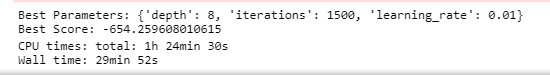

In [41]:
#Best Parameters
from IPython.display import Image
Image(filename='catboost best parameters.jpg') # please uncomment this line and replace 'screenshot.png' by the correct filename

## Training model with optimized parameters and test set for final predictions

In [43]:
%%time

# Fill missing values in categorical columns
categorical_cols = ['country', 'industry', 'company_speciality', 'job_title', 'work_specialization', 'description']
for col in categorical_cols:
    df_main_wages[col].fillna('Unknown', inplace=True)  # Fill NaN with 'Unknown' or any suitable placeholder

# Before dropping 'job_id' and 'company_id', create a separate DataFrame to retain these IDs
ids_df = df_main_wages[['job_id', 'company_id']]

# Drop 'job_id' and 'company_id' columns
X = df_main_wages.drop(['average_hourly_rate', 'job_id', 'company_id', 'pay_period'], axis=1)
y = df_main_wages['average_hourly_rate']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Initialize CatBoostRegressor model
model = CatBoostRegressor(iterations=1500, depth=8, verbose=0, learning_rate=0.01, loss_function='RMSE')

# Train the model
model.fit(X_train, y_train, cat_features=categorical_cols)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R-squared
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R-squared for train set: {round(r2_train, 3)}, and for test set: {round(r2_test, 3)}")

# Get feature importances
feature_importance = model.get_feature_importance(prettified=True)

feature_importance

R-squared for train set: 0.546, and for test set: 0.309
CPU times: total: 1min 39s
Wall time: 33.8 s


,Feature Id,Importances
0,industry,27.041399
1,work_specialization,26.142355
2,company_speciality,16.815623
3,job_title,9.825893
4,country,9.683247
5,company_size,8.120869
6,description,2.370614


## Predicting wages for unavailable data using trained CatBoost model






In [45]:
# Filtering out values from df_main based on job_id that are present in df_main_wages
df_main_filtered = df_main.merge(df_main_wages['job_id'], on='job_id', how='left', indicator=True)
df_main_filtered = df_main_filtered[df_main_filtered['_merge'] == 'left_only']
df_main_filtered.drop(columns=['_merge'], inplace=True)

# Fill missing values in categorical columns in df_main_wages
categorical_cols = ['country', 'industry', 'company_speciality', 'job_title', 'work_specialization', 'description']
for col in categorical_cols:
    df_main_wages[col].fillna('Unknown', inplace=True)  # Convert NaN to 'Unknown'

columns_to_drop_filtered = ['job_id', 'company_id', 'max_salary', 'min_salary', 'med_salary', 'currency', 'compensation_type', 'pay_period']
X_filtered = df_main_filtered.drop(columns=columns_to_drop_filtered, axis=1)

# Replace NaNs in categorical columns in X_filtered with 'Unknown'
for col in categorical_cols:
    X_filtered[col].fillna('Unknown', inplace=True)

# Make predictions on df_main_filtered using the trained model
predictions = model.predict(X_filtered)

# Merge 'df_main_filtered' with 'result_df_with_ids' to include 'job_id' and 'company_id'
df_main_filtered = df_main_filtered.merge(result_df_with_ids[['job_id', 'company_id']], how='left', on=['job_id', 'company_id'])
df_main_filtered['Predicted_Hourly_Rate'] = predictions

## Visualization: comparing average hourly rates by work specialization

In [15]:
# Calculate average hourly rate for each work specialization in df_main_wages and df_main_filtered
avg_hourly_rate_wages = df_main_wages[df_main_wages['work_specialization'] != 'Unknown'] \
    .groupby('work_specialization')['average_hourly_rate'].mean()
avg_hourly_rate_filtered = df_main_filtered[df_main_filtered['work_specialization'] != 'Unknown'] \
    .groupby('work_specialization')['Predicted_Hourly_Rate'].mean()

# Get unique work specializations
work_specializations = sorted(set(avg_hourly_rate_wages.index) | set(avg_hourly_rate_filtered.index))

# Create bar positions
bar_positions = np.arange(len(work_specializations))

# Get average hourly rates for each work specialization, fill NaN with 0 for missing values
avg_hourly_rate_wages = [avg_hourly_rate_wages.get(spec, 0) for spec in work_specializations]
avg_hourly_rate_filtered = [avg_hourly_rate_filtered.get(spec, 0) for spec in work_specializations]

# Set figure size and DPI
plt.figure(figsize=(14,8), dpi=1000)

# Plotting bars for job postings with known wages and predicted wages
plt.bar(bar_positions - 0.2, avg_hourly_rate_wages, width=0.4, label='Known Wages')
plt.bar(bar_positions + 0.2, avg_hourly_rate_filtered, width=0.4, label='Predicted Wages')

# Set x-axis labels and tick positions
plt.xticks(bar_positions, work_specializations, rotation=90)
plt.xlabel('Work Specialization')
plt.ylabel('Average Hourly Rate')
plt.title('Comparison of Average Hourly Rates by Work Specialization')
plt.legend()
plt.tight_layout()
plt.show()

## Visualization: Top 30 highest payed industreis

C:\Users\joose\AppData\Local\Temp\ipykernel_12908\3425656102.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='industry', y='average_hourly_rate', data=top_30_df, ci=None, order=top_30_industries)


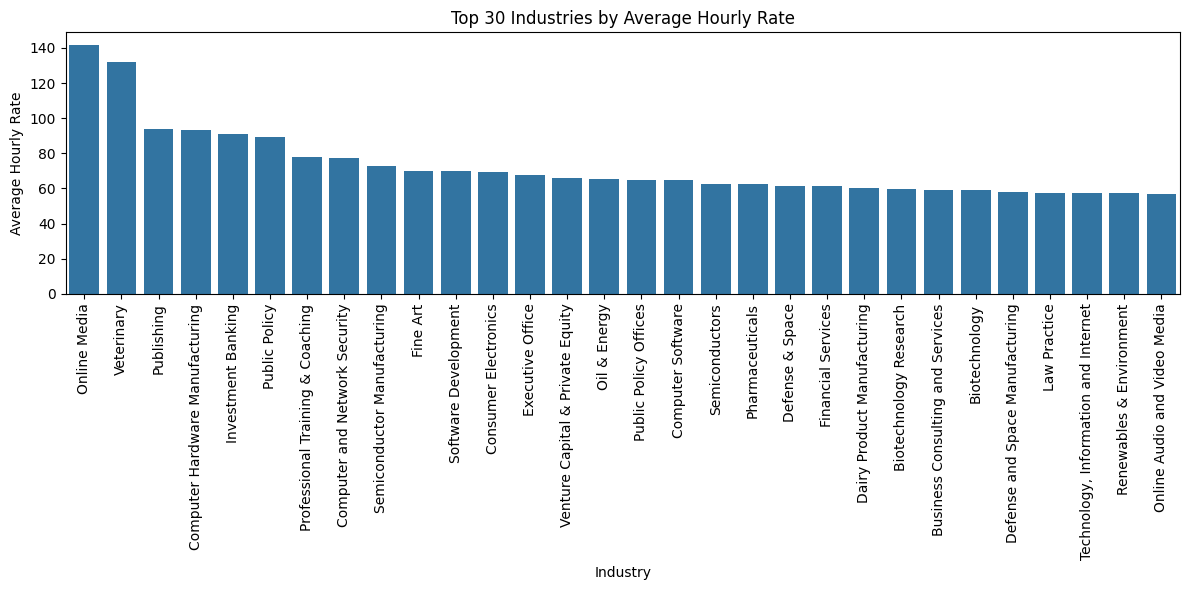

In [46]:
# Calculate average hourly rate for each industry
industry_avg_rate = df_main_wages.groupby('industry')['average_hourly_rate'].mean().sort_values(ascending=False)

# Select top 30 industries
top_30_industries = industry_avg_rate.head(30).index.tolist()

# Filter dataframe for the top 30 industries
top_30_df = df_main_wages[df_main_wages['industry'].isin(top_30_industries)]

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='industry', y='average_hourly_rate', data=top_30_df, ci=None, order=top_30_industries)
plt.xticks(rotation=90)
plt.xlabel('Industry')
plt.ylabel('Average Hourly Rate')
plt.title('Top 30 Industries by Average Hourly Rate')
plt.tight_layout()
plt.show()


## Frequency of Work Specializations in Job Postings

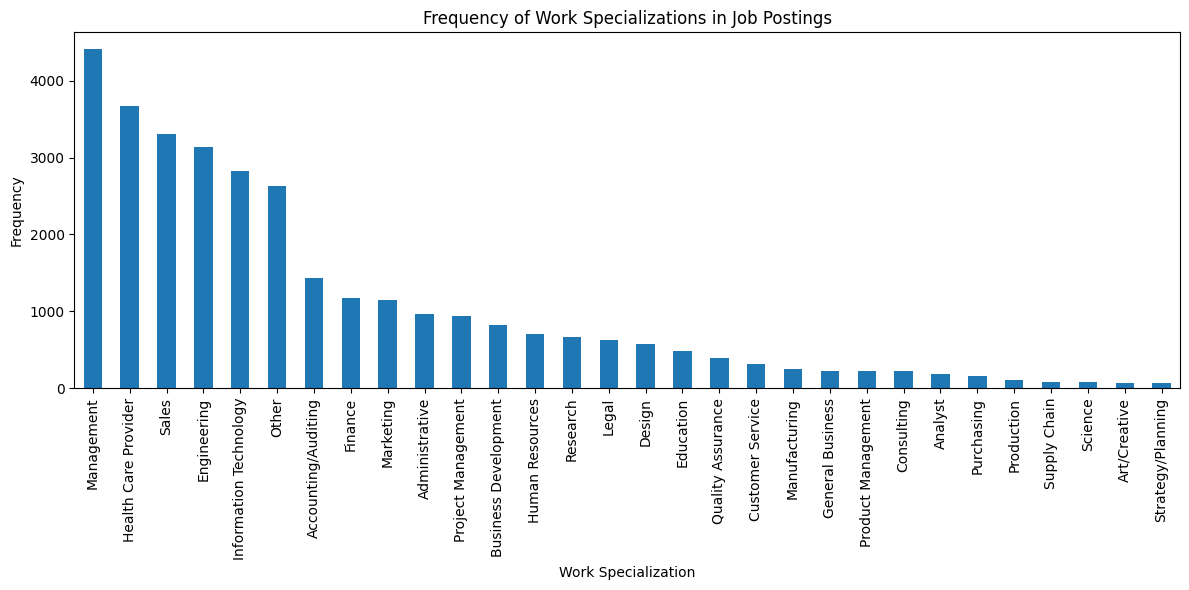

In [47]:
# Grouping by 'work_specialization' and getting the count for each specialization
work_specialization_counts = df_main['work_specialization'].value_counts()

# Taking top 30 specializations based on count
top_30_specializations = work_specialization_counts.head(30)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
top_30_specializations.plot(kind='bar')
plt.xlabel('Work Specialization')
plt.ylabel('Frequency')
plt.title('Frequency of Work Specializations in Job Postings')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.tight_layout()
plt.show()